In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff

import collections

from absl import app

import nest_asyncio
nest_asyncio.apply()

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

from keras.backend import print_tensor

import sys
sys.path.append("/home/tester/Desktop/TF/federated/tensorflow_federated/examples/simple_fedavg")
print(sys.path)
import simple_fedavg_tff

2022-06-14 06:02:43.447893: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-14 06:02:43.447924: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


['/home/tester/Desktop/TF/TFF', '/usr/lib/python39.zip', '/usr/lib/python3.9', '/usr/lib/python3.9/lib-dynload', '', '/home/tester/venv/lib/python3.9/site-packages', '/home/tester/Desktop/TF/federated/tensorflow_federated/examples/simple_fedavg']
['/home/tester/Desktop/TF/TFF', '/usr/lib/python39.zip', '/usr/lib/python3.9', '/usr/lib/python3.9/lib-dynload', '', '/home/tester/venv/lib/python3.9/site-packages', '/home/tester/Desktop/TF/federated/tensorflow_federated/examples/simple_fedavg', '/home/tester/Desktop/TF/federated/tensorflow_federated/examples/simple_fedavg']


In [2]:
# Training hyperparameters
TOTAL_ROUNDS = 350 #NUMBER OF TOTAL TRAINING ROUNDS
ROUNDS_PER_EVAL = 1 #HOW OFTEN TO EVALUATE
TRAIN_CLIENTS_PER_ROUND = 6 #HOW MANY CLIENTS TO SAMPLE PER ROUND
CLIENT_EPOCHS_PER_ROUND = 2 #NUMBER OF EPOCHS IN THE CLIENT TO TAKE PER ROUND
BATCH_SIZE = 256 #BATCH SIZE USED ON THE CLIENT
TEST_BATCH_SIZE = 64 #MINIBATCH SIZE OF TEST DATA
SERVER_LEARNING_RATE = 0.001 #SERVER LEARNING RATE
CLIENT_LEARNING_RATE = 0.00001 #CLIENT LEARNING RATE
NUM_CLIENTS = 50

In [3]:
df = pd.read_csv("../datasets/TON_IoT-Datasets/Train_Test_datasets/Train_Test_IoT_dataset/Train_Test_IoT_Modbus.csv")
df.head()
reduced_df = df[["FC1_Read_Input_Register", "FC2_Read_Discrete_Value", "FC3_Read_Holding_Register", "FC4_Read_Coil", "label"]]
df = reduced_df


In [4]:
# Percentage malware
perc = len(df.loc[df['label']==1])/len(df)
print(perc)

0.3151489061949673


In [5]:
# Balance dataset
num_anom = len(df.loc[df['label']==1])
df_anom = df.loc[df['label']==1]
df_normal = df.loc[df['label']==0]
df_normal = df_normal.sample(num_anom, replace=False)
df_concated = pd.concat([df_normal, df_anom])
df = df_concated

# Percentage malware
perc = len(df.loc[df['label']==1])/len(df)
print(perc)

0.5


In [6]:
labels = df.pop('label')

In [7]:
# Normalize
data_scaled = df.copy()
min_max_scaler = MinMaxScaler()
#data_scaled[["src_port", "dst_port", "src_bytes", "dst_bytes", "missed_bytes"]] = min_max_scaler.fit_transform(data_scaled[["src_port", "dst_port", "src_bytes", "dst_bytes", "missed_bytes"]])
data_scaled[data_scaled.columns] = min_max_scaler.fit_transform(data_scaled[data_scaled.columns])

In [8]:
data_scaled['label'] = labels

In [9]:
train, test = train_test_split(data_scaled, test_size=0.2)

train.head()

,FC1_Read_Input_Register,FC2_Read_Discrete_Value,FC3_Read_Holding_Register,FC4_Read_Coil,label
13342,0.555160,0.756191,0.506799,0.370220,1
1030,0.599783,0.409766,0.804182,0.069369,1
12565,0.514200,0.720516,0.310248,0.139332,1
14903,0.447480,0.712459,0.604212,0.420728,1
9816,0.830146,0.421149,0.442228,0.118107,0


In [10]:
# Separe normal and anomaly classes
train_labels = train['label'].astype(bool).copy()
test_labels = test['label'].astype(bool).copy()

normal_train_data = train[~train_labels]
normal_test_data = test[~test_labels]

anomalous_train_data = train[train_labels]
anomalous_test_data = test[test_labels]

In [11]:

#IID or NOIID? SPLIT DATA AMONG CLIENTS
client_id = np.random.choice(range(NUM_CLIENTS), size=len(normal_train_data), replace=True)
#df['client_id'] = client_id

In [12]:
#TRAIN: Create a dict where keys are client ids format for tff.simulation.datasets.TestClientData
normal_train_cl_dict = {}
for id in range(NUM_CLIENTS):
    tmp_train_df = normal_train_data.loc[client_id == id]
    tmp_train_dict = {name: np.array(value) 
                         for name, value in tmp_train_df.items()}
    normal_train_cl_dict[str(id)]=tmp_train_dict.copy()

In [13]:
#Determine max_client_ds_size
max_client_ds_size = -1
for id in range(NUM_CLIENTS):
    tmp_len = len(normal_train_data.loc[client_id == id])
    if(tmp_len > max_client_ds_size):
        max_client_ds_size = tmp_len

In [14]:
# TEST
tmp_test_dict = {name: np.array(value)
    for name, value in normal_test_data.items()}
normal_test_cl_dict = {'0': tmp_test_dict}
normal_test_ds_size = len(normal_test_data)

In [15]:
#CONVERT TO TFF DATASET
#netw_ds = tf.data.Dataset.from_tensor_slices((netw_features_dict, netw_labels))
#netw_ds = tf.data.Dataset.from_tensor_slices(netw_features_dict)
normal_train_fd_ds = tff.simulation.datasets.TestClientData(normal_train_cl_dict)
normal_test_fd_ds = tff.simulation.datasets.TestClientData(normal_test_cl_dict)




2022-06-14 06:02:46.291646: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-14 06:02:46.291677: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-14 06:02:46.291694: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (debian): /proc/driver/nvidia/version does not exist
2022-06-14 06:02:46.291903: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Test FedAVG

In [16]:
def evaluate(keras_model, test_dataset):
  """Evaluate the acurracy of a keras model on a test dataset."""
  #metric = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
  metric = tf.keras.metrics.SparseCategoricalCrossentropy()
  for batch in test_dataset:
    #DONT KNOW WHAT DOES
    predictions = keras_model(batch['x'])
    metric.update_state(y_true=batch['y'], y_pred=predictions)
  return metric.result()

def get_custom_dataset():
  def element_fn(element):
    features = tf.convert_to_tensor([element["FC1_Read_Input_Register"], element["FC2_Read_Discrete_Value"], element["FC3_Read_Holding_Register"], element["FC4_Read_Coil"]], dtype=tf.float32)
    #features = tf.convert_to_tensor([element["FC1_Read_Input_Register"], element["FC2_Read_Discrete_Value"]], dtype=tf.float32)
    #print_tensor(features)
    return collections.OrderedDict(
      # tf.expand_dims? ADD MORE COLUMNS
        x=features, y=element['label'])

  def preprocess_train_dataset(dataset):
    # Use buffer_size same as the maximum client dataset size,
    return dataset.map(element_fn).shuffle(buffer_size=max_client_ds_size).repeat(
        count=CLIENT_EPOCHS_PER_ROUND).batch(
            BATCH_SIZE, drop_remainder=False)
  def preprocess_test_dataset(dataset):
    return dataset.map(element_fn).batch(
        TEST_BATCH_SIZE, drop_remainder=False)
  netw_train = normal_train_fd_ds.preprocess(preprocess_train_dataset)
  netw_test = preprocess_test_dataset(
      normal_test_fd_ds.create_tf_dataset_from_all_clients())
  return netw_train, netw_test


def create_fedavg_model(only_digits=True):
  """The CNN model used in https://arxiv.org/abs/1602.05629.

  Args:
    only_digits: If True, uses a final layer with 10 outputs, for use with the
      digits only EMNIST dataset. If False, uses 62 outputs for the larger
      dataset.

  Returns:
    An uncompiled `tf.keras.Model`.
  """
  initializer = tf.keras.initializers.GlorotNormal(seed=0)
  return tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(4,)),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(8, activation="relu"),
    tf.keras.layers.Dense(2, activation="relu"),
    tf.keras.layers.Dense(8, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(4, activation="sigmoid")
    ])


def server_optimizer_fn():
  return tf.keras.optimizers.Adam(learning_rate=SERVER_LEARNING_RATE)


def client_optimizer_fn():
  return tf.keras.optimizers.Adam(learning_rate=CLIENT_LEARNING_RATE)

In [17]:
#if len(argv) > 1:
#  raise app.UsageError('Too many command-line arguments.')
# If GPU is provided, TFF will by default use the first GPU like TF. The
# following lines will configure TFF to use multi-GPUs and distribute client
# computation on the GPUs. Note that we put server computatoin on CPU to avoid
# potential out of memory issue when a large number of clients is sampled per
# round. The client devices below can be an empty list when no GPU could be
# detected by TF.

train_loss_list = []
val_loss_list = []

client_devices = tf.config.list_logical_devices('GPU')
server_device = tf.config.list_logical_devices('CPU')[0]
tff.backends.native.set_local_python_execution_context(
    server_tf_device=server_device, client_tf_devices=client_devices)
train_data, test_data = get_custom_dataset()
def tff_model_fn():
  """Constructs a fully initialized model for use in federated averaging."""
  keras_model = create_fedavg_model(only_digits=True)
  loss = tf.keras.losses.SparseCategoricalCrossentropy()
  #metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
  return tff.learning.from_keras_model(
      keras_model,
      loss=loss,
      #metrics=metrics,
      input_spec=train_data.element_type_structure)

iterative_process = simple_fedavg_tff.build_federated_averaging_process(
    tff_model_fn, server_optimizer_fn, client_optimizer_fn)
server_state = iterative_process.initialize()
# Keras model that represents the global model we'll evaluate test data on.
keras_model = create_fedavg_model(only_digits=True)
for round_num in range(TOTAL_ROUNDS):
  sampled_clients = np.random.choice(
      train_data.client_ids,
      size=TRAIN_CLIENTS_PER_ROUND,
      replace=False)
  sampled_train_data = [
      train_data.create_tf_dataset_for_client(client)
      for client in sampled_clients
  ]
  server_state, train_metrics = iterative_process.next(
      server_state, sampled_train_data)
  print(f'Round {round_num}')
  print(f'\tTraining metrics: {train_metrics}')
  train_loss_list.append(train_metrics.get('loss'))

  if round_num % ROUNDS_PER_EVAL == 0:
    server_state.model.assign_weights_to(keras_model)
    val_loss = evaluate(keras_model, test_data)
    val_loss_list.append(val_loss)
    print(f'\tValidation loss: {val_loss: .16f}')

Round 0
	Training metrics: OrderedDict([('loss', 1.3782827), ('num_examples', 3070), ('num_batches', 14)])
	Validation loss:  1.3661998510360718
Round 1
	Training metrics: OrderedDict([('loss', 1.3754873), ('num_examples', 3162), ('num_batches', 16)])
	Validation loss:  1.3607884645462036
Round 2
	Training metrics: OrderedDict([('loss', 1.3724794), ('num_examples', 3164), ('num_batches', 16)])
	Validation loss:  1.3551411628723145
Round 3
	Training metrics: OrderedDict([('loss', 1.3697572), ('num_examples', 3130), ('num_batches', 16)])
	Validation loss:  1.3492884635925293
Round 4
	Training metrics: OrderedDict([('loss', 1.3663739), ('num_examples', 3098), ('num_batches', 15)])
	Validation loss:  1.3432540893554688
Round 5
	Training metrics: OrderedDict([('loss', 1.3632569), ('num_examples', 3098), ('num_batches', 15)])
	Validation loss:  1.3370329141616821
Round 6
	Training metrics: OrderedDict([('loss', 1.3599375), ('num_examples', 3064), ('num_batches', 14)])
	Validation loss:  1.33

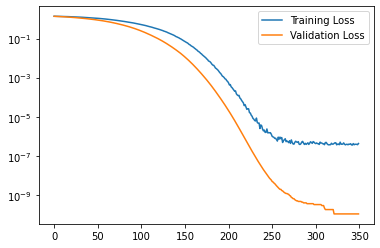

In [28]:
plt.plot(train_loss_list, label="Training Loss")
plt.plot(val_loss_list, label="Validation Loss")
plt.yscale('log')
plt.legend()

In [29]:
normal_test_features = normal_test_data.copy()
normal_test_features.pop('label')
tensor_normal_test_features = tf.convert_to_tensor(normal_test_features, dtype=tf.float32)

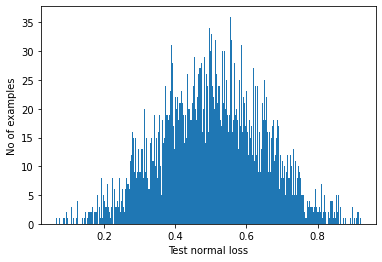

In [30]:
reconstruct_normal = keras_model(tensor_normal_test_features)
normal_test_loss = tf.keras.losses.mae(y_true=normal_test_features, y_pred=reconstruct_normal)
plt.hist(normal_test_loss[None,:], bins=300)
plt.xlabel("Test normal loss")
plt.ylabel("No of examples")
plt.show()

In [31]:
anomal_test_features = anomalous_test_data.copy()
anomal_test_features.pop('label')
tensor_anomal_test_features = tf.convert_to_tensor(anomal_test_features, dtype=tf.float32)

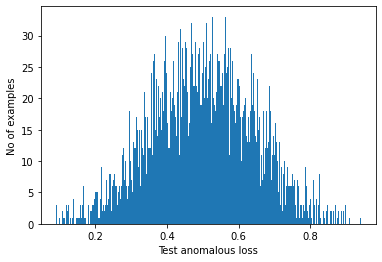

In [32]:
reconstruct_anomal = keras_model(tensor_anomal_test_features)
anomal_test_loss = tf.keras.losses.mae(y_true=anomal_test_features, y_pred=reconstruct_anomal)
plt.hist(anomal_test_loss[None,:], bins=300)
plt.xlabel("Test anomalous loss")
plt.ylabel("No of examples")
plt.show()

Select a value a std greater from the mean

In [33]:
threshold = np.mean(normal_test_loss) + np.std(normal_test_loss)
print("Threshold: ", threshold)

Threshold:  0.64920574


Classify instance as abnormal if the reconstruction error is greater than the threshold

In [34]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mean_squared_error(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions))) #sensitivity
  print("F1 = {}".format(f1_score(labels, predictions)))
  print("ROC_AUC = {}".format(roc_auc_score(labels, predictions)))



In [35]:
# Results dont make sense give more weight to anomaly class in the learning process
mix_test = test.copy()
mix_labels = mix_test.pop('label')
preds = predict(keras_model, np.array(mix_test), threshold)
print_stats(preds, mix_labels)

Accuracy = 0.5047338196492317
Precision = 0.5041374920432845
Recall = 0.9768732654949122
F1 = 0.665057205836045
ROC_AUC = 0.5015616327474561


## Old

In [26]:
def main(argv):
  if len(argv) > 1:
    raise app.UsageError('Too many command-line arguments.')
  # If GPU is provided, TFF will by default use the first GPU like TF. The
  # following lines will configure TFF to use multi-GPUs and distribute client
  # computation on the GPUs. Note that we put server computatoin on CPU to avoid
  # potential out of memory issue when a large number of clients is sampled per
  # round. The client devices below can be an empty list when no GPU could be
  # detected by TF.
  client_devices = tf.config.list_logical_devices('GPU')
  server_device = tf.config.list_logical_devices('CPU')[0]
  tff.backends.native.set_local_python_execution_context(
      server_tf_device=server_device, client_tf_devices=client_devices)
  train_data, test_data = get_custom_dataset()

  def tff_model_fn():
    """Constructs a fully initialized model for use in federated averaging."""
    keras_model = create_fedavg_model(only_digits=True)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
    return tff.learning.from_keras_model(
        keras_model,
        loss=loss,
        metrics=metrics,
        input_spec=train_data.element_type_structure)

  iterative_process = simple_fedavg_tff.build_federated_averaging_process(
      tff_model_fn, server_optimizer_fn, client_optimizer_fn)
  server_state = iterative_process.initialize()
  # Keras model that represents the global model we'll evaluate test data on.
  keras_model = create_fedavg_model(only_digits=True)
  for round_num in range(TOTAL_ROUNDS):
    sampled_clients = np.random.choice(
        train_data.client_ids,
        size=TRAIN_CLIENTS_PER_ROUND,
        replace=False)
    sampled_train_data = [
        train_data.create_tf_dataset_for_client(client)
        for client in sampled_clients
    ]
    server_state, train_metrics = iterative_process.next(
        server_state, sampled_train_data)
    print(f'Round {round_num}')
    print(f'\tTraining metrics: {train_metrics}')
    if round_num % ROUNDS_PER_EVAL == 0:
      server_state.model.assign_weights_to(keras_model)
      accuracy = evaluate(keras_model, test_data)
      print(f'\tValidation accuracy: {accuracy * 100.0:.2f}%')

In [27]:
# import nest_asyncio
# nest_asyncio.apply()

# try:
#     app.run(main([None]))
# except:
#     print("exec end error")